<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_model_building_option2_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet-Unet
  This notebook is trying to build unet architecture using ResNet50 as base model.

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

## Model Parameters

In [4]:
#Set global parameters here
BASE_MODEL = "ResNet50"
MODEL_NAME  = "Option-2" + "." + BASE_MODEL
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)
WEIGHTS_FILE = MODEL_NAME+"/" + "weights.best.h5"
HISTORY_FILE = MODEL_NAME+"/" +"history.csv"
BATCH_SIZE = 8
IMAGE_SIZE = 224 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = False #True , change it to force training

ALPHA = 1.0
EPOCHS = 5 


In [5]:
from pylab import rcParams
# # register_matplotlib_converters()
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 6

In [6]:
#Load Utility functions
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
     |████████████████████████████████| 35.5MB 89kB/s 
Setting baseModel : ResNet50
<module 'tensorflow.keras.applications.resnet50' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/applications/resnet50/__init__.py'>
global BaseModel; BaseModel =np.ResNet50
global preprocess_input; preprocess_input =np.preprocess_input
<class 'function'>
/content/drive/My Drive/rsna-pneumonia-detection-challenge
<function ResNet50 at 0x7f34a8809bf8> <function preprocess_input at 0x7f34a8809d90>


In [7]:
baseModel,preprocess_input

(<function tensorflow.python.keras.applications.resnet.ResNet50>,
 <function tensorflow.python.keras.applications.resnet.preprocess_input>)

In [8]:
#Loading full data
full_df,bbox_map,class_enc = loadData()

Loading full CXR info
Loading bbox map


In [9]:
full_df.head(1)

,Unnamed: 0,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/0004cfab-14fd-4e49-80ba-6...


In [10]:
full_df.drop(full_df.columns[0],inplace=True,axis=1)

## Black border removal

In [11]:
#Check for black borders
# from PIL import Image, ImageChops


def is_there_a_border(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    return bbox != (0,0,im.size[0],im.size[1])
    # return all((bbox[0], bbox[1], bbox[2]) < im.size[0], bbox[3] < im.size[1])
    # return all((bbox[0], bbox[1], (bbox[0] + bbox[2]) <= im.size[0], 
    #                               (bbox[1] + bbox[3]) <= im.size[1]))
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
    else:
      return im

# im = Image.open("bord3.jpg")
# im = trim(im)
# im.show()

In [12]:

# jpg_path = "/content/drive/My Drive/Option-1.Retinanet/stage_2_train_images/"

# jpgs = os.listdir(jpg_path)
# f, ax = plt.subplots(1, 2, figsize=(10,7))
# black_borders = []
# for i, f in enumerate(jpgs):
#   file = jpg_path + f
#   im = Image.open(file)
#   # ax[0].imshow(im, cmap=plt.cm.bone)
#   # ax[0].set_title("With black border({})".format((np.asarray(im)).shape))
#   if (is_there_a_border(im)):
#     black_borders.append(file)
#   im.close()
    # print('opening image:',file)
    # tim = trim(im)
    # ax[1].imshow(tim,cmap=plt.cm.bone)
    # ax[1].set_title("Black border removed({}):".format(np.asarray(tim).shape))
    # break;
# #end of black border removal


In [13]:
# len(jpgs),len(black_borders)

In [14]:
bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985']

{'bboxes': [[318, 316, 478, 170], [375, 660, 402, 146]],
 'path': 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'}

In [15]:
full_df[full_df.patientId == '000db696-cf54-4385-b10b-6b16fbb3f985']

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,2,25,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/000db696-cf54-4385-b10b-6...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,2,25,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/000db696-cf54-4385-b10b-6...


In [16]:
pd_label = pd.read_csv('stage_2_train_labels.csv')
pd_label[pd_label.patientId == '000db696-cf54-4385-b10b-6b16fbb3f985']

,patientId,x,y,width,height,Target
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1


In [17]:
print('{}:Total Pneumonia Patient'.format(len(full_df[full_df.Target == 1])))

9555:Total Pneumonia Patient


In [18]:
#Split the dataset  into 3 train/valid/test
unbalanced_train_df, valid_df, test_df = splitData(full_df)

(21347, 14) training data
(5337, 14) raw validation data
(2668, 14) Validation data
(2669, 14) test data


In [19]:
unbalanced_train_df[unbalanced_train_df.Target == 1].shape[0]

4810

8416 Final training size


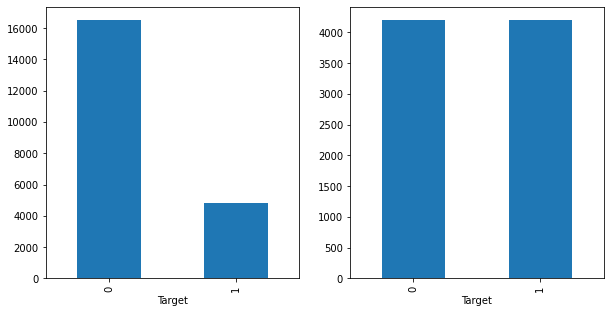

In [20]:
import matplotlib.pyplot as plt
TRAIN_SAMPLES = 8416
#Balancing training set
train_df = balance_df(unbalanced_train_df,TRAIN_SAMPLES)
print(train_df.shape[0], 'Final training size')

In [21]:
def addConvLayer(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    
    return conv

def build_ResNet50():
    model = BaseModel(input_shape =(IMAGE_SIZE, IMAGE_SIZE, 3),include_top = False, weights = 'imagenet')
     
    model.trainable = False
    for layer in model.layers:
        layer.trainable = False
    # Add all the UNet layers here
    convLayer_112by112 = model.get_layer("conv1_relu").output
    convLayer_56by56 = model.get_layer("conv2_block3_out").output 
    convLayer_28by28 = model.get_layer("conv3_block4_out").output 
    convLayer_14by14 = model.get_layer("conv4_block6_out").output 
    convLayer_7by7 = model.get_layer("conv5_block3_out").output 
    # The last layer of resnet model(conv5_block3_out) is of dimensions (7x7x2048)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNet
    # concatinate with the original image layer of the same size from ResNet50
    up14by14 = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    upConvLayer_14by14 = addConvLayer(up14by14, 256, "upConvLayer_14by14_1")
    upConvLayer_14by14 = addConvLayer(upConvLayer_14by14, 256, "upConvLayer_14by14_2")
    
    up28by28 = Concatenate()([UpSampling2D()(upConvLayer_14by14), convLayer_28by28])
    upConvLayer_28by28 = addConvLayer(up28by28, 256, "upConvLayer_28by28_1")
    upConvLayer_28by28 = addConvLayer(upConvLayer_28by28, 256, "upConvLayer_28by28_2")
     
    up56by56 = Concatenate()([UpSampling2D()(upConvLayer_28by28), convLayer_56by56])
    upConvLayer_56by56 = addConvLayer(up56by56, 256, "upConvLayer_56by56_1")
    upConvLayer_56by56 = addConvLayer(upConvLayer_56by56, 256, "upConvLayer_56by56_2")    
    
    up112by112 = Concatenate()([UpSampling2D()(upConvLayer_56by56), convLayer_112by112])
    upConvLayer_112by112 = addConvLayer(up112by112, 256, "upConvLayer_112by112_1")
    upConvLayer_112by112 = addConvLayer(upConvLayer_112by112, 256, "upConvLayer_112by112_2")   
    
    up224by224 = UpSampling2D(name="resnet_last")(upConvLayer_112by112) # upsample to 224x224
    upConvLayer_224by224 = addConvLayer(up224by224, 256, "upConvLayer_224by224_1")
    upConvLayer_224by224 = addConvLayer(upConvLayer_224by224, 256, "upConvLayer_224by224_2")   

    # Add classification layer
    upConvLayer_224by224 = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(upConvLayer_224by224)
    upConvLayer_224by224 = Reshape((IMAGE_SIZE, IMAGE_SIZE))(upConvLayer_224by224) 

    return Model(inputs=model.input, outputs=upConvLayer_224by224)
   
    

In [22]:
len(np.unique(train_df["path"].to_numpy()))

8416

In [23]:
# BATCH_SIZE = 8
# IMAGE_SIZE = 224
# IMG_WIDTH = 1024
train_gen = MyDataGenerator(train_df)
valid_gen = MyDataGenerator(valid_df)

print(len(train_gen), "# of iterations in one train epoch")
print(len(valid_gen), "# of iterations in one validate epoch")

8416 :No of generator Image
2668 :No of generator Image
1052 # of iterations in one train epoch
333 # of iterations in one validate epoch


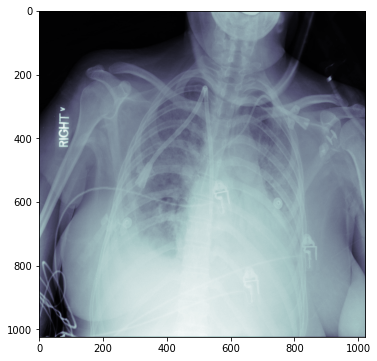

In [25]:
path = bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('path')
img = train_gen.getImage(path)
plt.imshow(img, cmap=plt.cm.bone)

In [26]:
imageSet = train_gen[870][0]
maskSet = train_gen[870][1]   

In [27]:
imageSet.shape,maskSet.shape

((8, 224, 224, 3), (8, 224, 224))

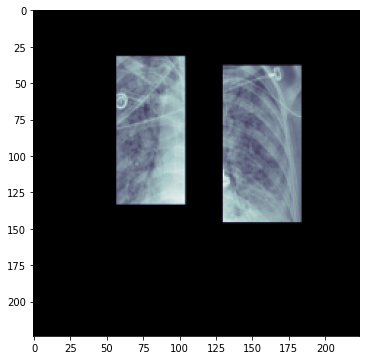

In [28]:
showMaskedImage(imageSet,maskSet,4)

## Build model

In [29]:
#Add optimizar,check point & early stopping 
#Initial learning rate 0.0001, try other 0.001 & default beta-1 & 2
lr = 1e-4
decay = lr/EPOCHS # or in the factor of 10
adamOptimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
checkpoint = ModelCheckpoint(WEIGHTS_FILE, monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping( monitor="val_loss", patience=2, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min")

mobile_unet_Model = build_ResNet50()
mobile_unet_Model.compile(loss=iou_loss, optimizer=adamOptimizer, metrics=[mean_iou]) 

94773248/94765736 [==============================] - 1s 0us/step


##Model Fit

In [30]:
%%time
history = pd.DataFrame()

if (os.path.isfile(WEIGHTS_FILE) & (FORCE_TRAINING == False) ):
  mobile_unet_Model.load_weights(WEIGHTS_FILE)
  history = loadHistory(HISTORY_FILE)
else:
  if (os.path.isfile(WEIGHTS_FILE)):
    mobile_unet_Model.load_weights(WEIGHTS_FILE)
  history = mobile_unet_Model.fit(train_gen,   # (X_train, y_train)
                        epochs=EPOCHS,
                        validation_data=valid_gen,#(X_valid, y_valid)
                        callbacks=[checkpoint, reduce_lr, stop],
                        shuffle=True,
                        verbose=1)
  
  history = saveHistory(history,HISTORY_FILE)

CPU times: user 331 ms, sys: 102 ms, total: 433 ms
Wall time: 1.8 s


## History

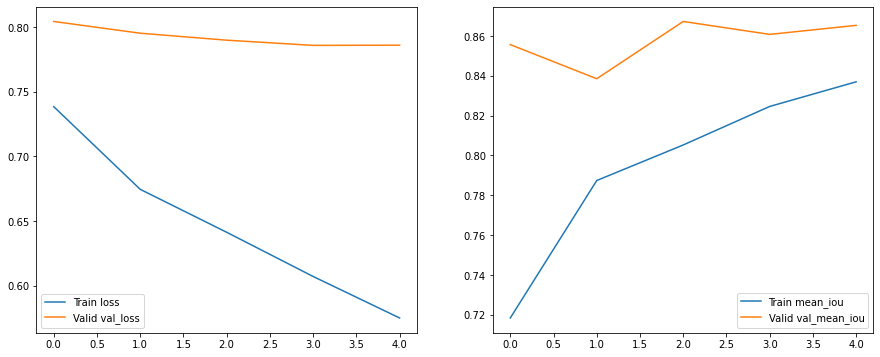

In [31]:
plot_his(history)

## Predict sample image

In [32]:
imageSet = valid_gen[9][0]
maskSet = valid_gen[9][1]
predMaskSet = mobile_unet_Model.predict(imageSet)


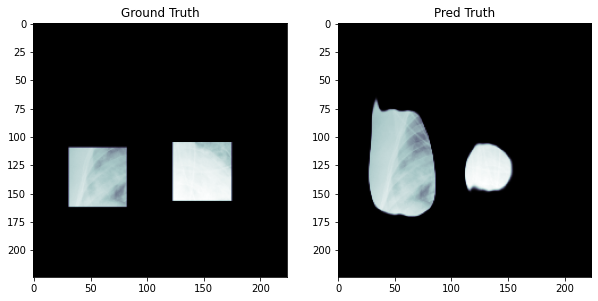

In [34]:
loc = 5
showMaskedImage(imageSet,maskSet,loc,predMaskSet)

**Red** Bounding box: **PREDICTED**
**Blue** bouding box: **TRUTH**


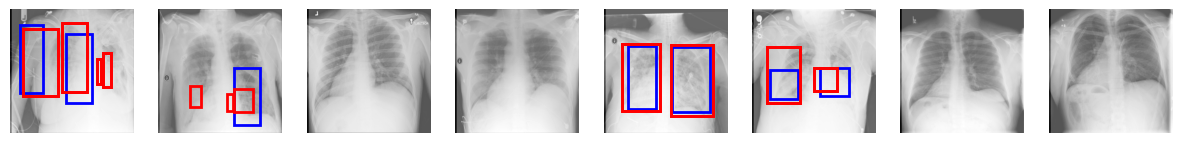

In [35]:
#Show prediction on sample batch
showPredMaskedBatch(imageSet,maskSet,predMaskSet)

## Predict on test data set

In [36]:
iou = 0.3
no_test = test_df.shape[0]
pred_file = MODEL_NAME + '/prediction.' +str(iou)+ str(no_test) +'.csv'
FORCE_PREDICTION = False;
pred_test_df = pd.DataFrame()
pred_test_df = 0
test_y = 0;
pred_y = 0
if ((os.path.isfile(pred_file) == False) | (FORCE_PREDICTION)):
  print('Predicting on test dataframe')
  #Pass test dataframe, bouding box map, trained mode, file to dump prediction, IoU threshold
  pred_test_df,test_y,pred_y = doMaskPrediction(test_df,bbox_map,mobile_unet_Model,pred_file,iou)
else:
  pred_test_df = pd.read_csv(pred_file)
  test_y = pred_test_df["Target"]
  pred_y = pred_test_df["predTarget"]
 
 

  0%|          | 0/333 [00:00<?, ?it/s]

Predicting on test dataframe
Number of Test Samples : 2669
2669 :No of generator Image
333 # of iterations in one test epoch


100%|██████████| 333/333 [20:05<00:00,  3.62s/it]

Prediction Complete!


In [37]:
len(set(pred_test_df[pred_test_df.predTarget == 1].patientId))

280

In [38]:
len(set(pred_test_df[pred_test_df.Target == 1].patientId))

600

##Show top IOU prediction

In [44]:
pred_test_df['iou'] = pred_test_df['iou'].apply(lambda x: 0 if x== 'NA' else float(x))
# pred_test_df['iou'] = pred_test_df['iou'].astype(float)
pred_test_df.sort_values("iou", ascending=False, inplace=True)

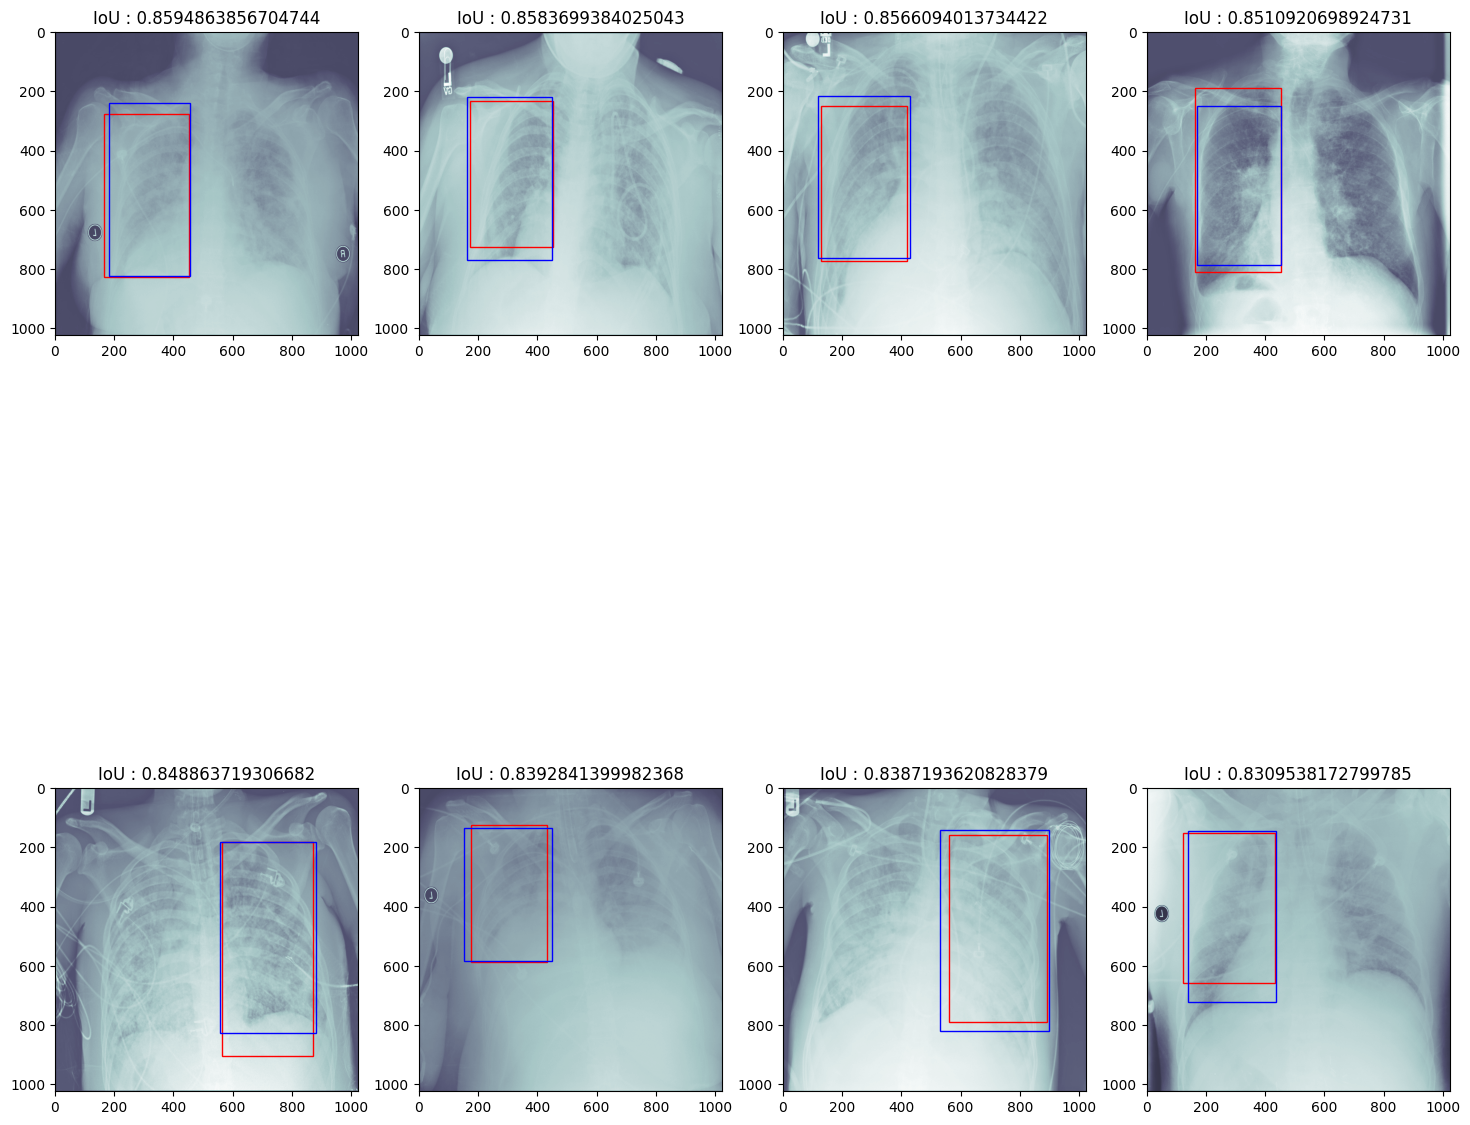

In [45]:
# pred_test_df = pd.read_csv(pred_file)
topNo = 8
show_top_prediction(pred_test_df,topNo)

In [46]:
pred_test_df.head()

,patientId,x,y,width,height,Target,class,x_pred,y_pred,width_pred,height_pred,predTarget,iou,class_pred
818,89306dc8-a4ee-4679-b183-984ddd00f2fc,164,278,289,549,1,Lung Opacity,182,238,275,585,1,0.859486,Lung Opacity
192,d3a565b6-929e-4db1-8cc2-2b59e64860b5,171,233,281,491,1,Lung Opacity,164,220,284,551,1,0.858370,Lung Opacity
220,c9ef5f00-e918-46d6-897f-ee78fc1310d5,128,251,290,522,1,Lung Opacity,119,216,311,546,1,0.856609,Lung Opacity
2206,35d5dba1-22ee-4f68-b28f-bd16ae96ae00,164,189,288,620,1,Lung Opacity,169,249,283,537,1,0.851092,Lung Opacity
2888,86f92091-0f8b-400e-9a13-f3d61ad724a5,563,181,307,723,1,Lung Opacity,558,183,324,644,1,0.848864,Lung Opacity


## Performance(Recall)

In [47]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(test_y, pred_y), "\n")
print("Classification Report:- \n", metrics.classification_report(test_y, pred_y))

Confusion Matrix:- 
 [[2064    0]
 [ 689  283]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.75      1.00      0.86      2064
           1       1.00      0.29      0.45       972

    accuracy                           0.77      3036
   macro avg       0.87      0.65      0.65      3036
weighted avg       0.83      0.77      0.73      3036



### Confidence score

## Conclusion